<img src="img/UBC_MDS_logo.PNG" width="150" height="150" align="right"/>

# DSCI 552 - Statistical Inference and Computation I

## Lecture 8: Maximum Likelihood Estimation

Alexi Rodríguez-Arelis

**November 2021**

# Today's Learning Goals

By the end of this lecture, you should be able to:

1. Explain the concept of maximum likelihood estimation (MLE).
2. Apply MLE for cases with one population parameter.

## Loading `R` Packages

Let us load the libraries for data wrangling, analysis, and plotting.

In [1]:
options(repr.plot.height = 6, repr.plot.width = 20)
options(repr.matrix.max.rows = 6)
source("scripts/support_functions.R")
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Estimating population parameters in a different way!

Let us go one step further on population parameter estimation. So far, we have dealt with single parameters in our confidence intervals and hypothesis testings.

Nonetheless, what happens if we want to estimate more than just a single parameter? There are many different statistical distributions (including the normal!) with more than one parameter.

We can use MLE for univariate or multivariate purposes. This method heavily relies on **a random sample of $n$ observations** coming from the population of interest.

## A first example!

Suppose we have an **empirical distribution** of standard deviations of gene expression for different genes. This empirical distribution corresponds to a random sample of standard deviations.

Moreover, we would like to estimate the parameters from the population this sample is coming from!

<center>
<br>
<img src="img/mle_motivation.png" width="750" height="750"/>
    <div style="text-align: center"><i>Image from Data Analysis for the Life Sciences (Irizarry and Love, 2016)</a></i></a></div>
</center>

### How can we do this? 

This illustration gives us some ideas. First, note the same histogram corresponding to the random sample appears in each cell of the grid. Second, the red line represents a given theoretical probability density function (PDF) under specific population parameters.

Now, we might wonder: *what red line fits the histogram better?*

### This is the intuition of MLE!

## What is the definition of MLE?

MLE is a method that, given some observed data and some assumed family of probability distributions, seeks to find values of the parameters that would make the observed data most likely to have occurred.

### Alternatively:

MLE is a method that, given some observed data and some assumed family of probability distributions, seeks to find the distribution that would make the observed data most likely to have occurred. The parameters specify this distribution.

These are the **EMPIRICAL** steps we follow for our previous example using MLE:

1. Firstly, we choose a family of theoretical distributions that we believe our observed sample distribution comes from. Here, we chose an [$F$-distribution](https://en.wikipedia.org/wiki/F-distribution). 

> **Heads-up:**  How we choose the family of distributions for our statistical modelling will be covered in more detail in **DSCI 562**.

2. Next, we vary the parameter(s) for that family of theoretical distributions to find a specific, single distribution that best fits the observed data. 

> **Note:** The $F$-distribution has two parameters ($d$ which controls the location and $s_0$ which controls the scale).

From the histograms above, can we do it just "by eye"? Not precisely. So how can we do this? MLE is one way. Let us now explore how.

## Some key ideas...

- We aim to estimate the parameters of a theoretical distribution (e.g., $\mu$ and/or $\sigma^2$ in the case of a normal distribution). 
- Therefore, we need to make a distributional assumption for our data - at the family level (choose a distribution: normal, exponential, Poisson, binomial, etc.).

> **Heads-up:** One crucial element to consider is the nature of our variable of interest (is it continuous or discrete?).

- Then, we play around with the parameters for that family of distributions to find the one that would be **most likely** given our data, and we choose the corresponding parametric **estimates**.
- To obtain these estimates, we use the **likelihood function**.

## But, what is the likelihood function?

Let us set another example. Suppose we draw a random sample of $n = 30$ observations from a *continuous population*.

In [2]:
sample_n30 <- tibble(values = c(
  24.9458614574341, 7.23174970992907, 4.16136401519179, 5.60304128237143,
  5.37929488345981, 1.40547217217847, 7.0701988485075, 2.84055356831115,
  0.894746121019125, 2.9016381111011, 3.19011222943664, 11.0930137682099,
  3.49700326472521, 46.2914818498428, 2.00653892990149, 2.87363994969391,
  11.4050390862658, 11.6616687767937, 12.8855835341646, 3.88483320176601,
  0.406148910522461, 25.7642258988289, 8.4743227359272, 4.17410666868091,
  1.84968510270119, 2.15972620035141, 10.5289600339151, 6.44162824716339,
  10.6035323139645, 66.6861112673485
))

Let us plot the empirical (sample) distribution as a histogram but using a density scale, as a first step:

In [3]:
hist_sample_n30 <- sample_n30 %>%
    ggplot() +
    geom_histogram(aes(values, ..density..), fill = "grey", color = "black", bins = 50) +
    theme(
      plot.title = element_text(size = 21, face = "bold"),
      axis.text = element_text(size = 15),
      axis.title = element_text(size = 21),
      legend.text = element_text(size = 21),
      legend.title = element_text(size = 18, face = "bold")
    ) +
    ggtitle("Histogram of a Continuous Random Sample of n = 30") +
    scale_colour_discrete(name = expression(paste("Rate (", lambda, ")"))) +
    labs(x = "Observed Value", y = "Density")

Note `y = ..density..` transforms the $y$-values on the histogram from counts to a density.

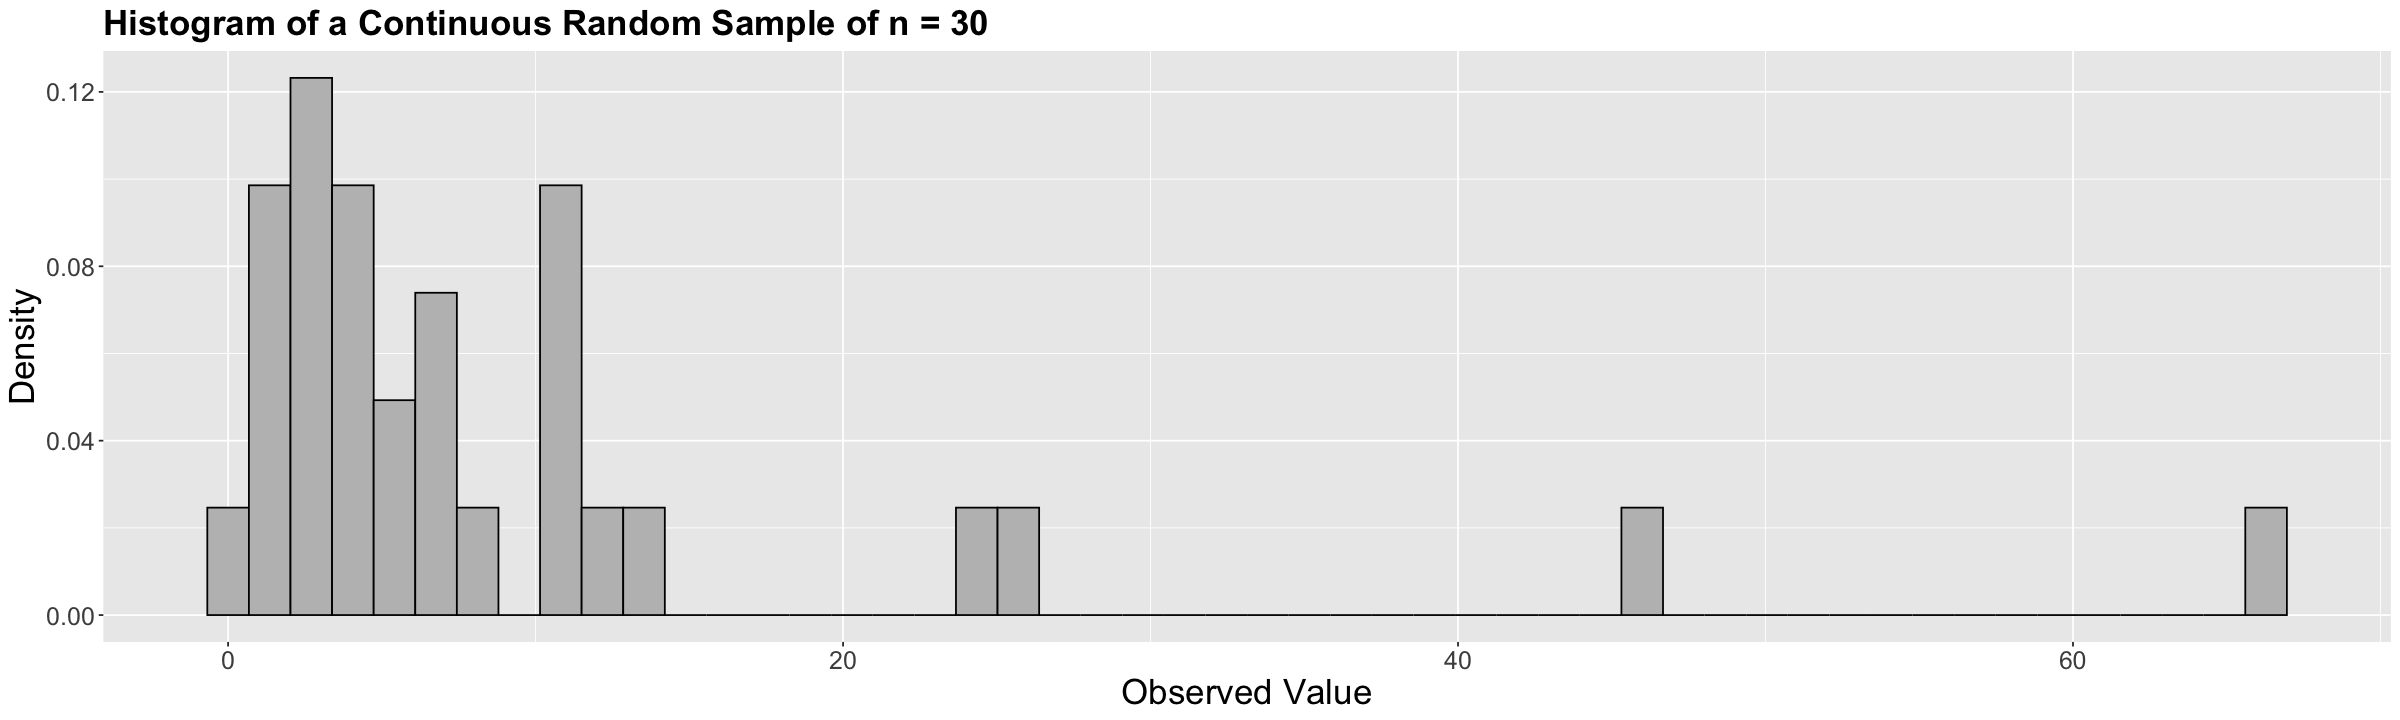

In [4]:
hist_sample_n30

We will assume it is an **exponential population** whose unknown parameter is $\lambda$. Therefore, **we aim to estimate $\lambda$ via the observed values in this random sample.** Moreover, given our distributional assumption, each observation is $y_i$ ($i = 1, \dots, 30$) with the following PDF:

$$
f_{Y_i}(y_i \mid \lambda) = \lambda \exp(-\lambda y_i).
$$

How can we obtain an estimate for $\lambda$? MLE is one possible approach to overcome this matter:

- First, we choose a theoretical distribution that we believe our sample's empirical distribution is coming. The equation above, $f_{Y_i}(y_i \mid \lambda)$, will be extremely useful. Here we chose a distribution such as the exponential given our right-skewed `hist_sample_n30` (the empirical distribution).

- Since it is a random sample, we assume all the $n$ observations are independent. This assumption leads to the following **joint PDF**:

$$
f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).
$$

Now, you might wonder: *where is the likelihood function?* The likelihood function is a function of the parameters of a given/chosen theoretical distribution.

It is equivalent (**mathematically!**) to the joint PDF (or probability mass function, PMF, if the random variables are discrete). **However, we have to change our perspective: we do not know the population parameter, but the sample's observed values**.

From our previous example with the joint PDF $f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda)$, this implicates:

$$\mathscr{l}(\lambda \mid y_1, \dots, y_n) = f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).$$

## How do we compute the likelihood?

### A smaller and different sample of $n = 3$

Let us suppose that we only have three observations (note the lowercases!): $y_1 = 0.8$, $y_2 = 2.1$, and $y_3 = 2.4$. Moreover, we also assume they come from the family of exponential distributions. The likelihood function would be the joint PDF of this sample:

$$\mathscr{l}(\lambda \mid y_1, y_2, y_3) = \lambda \exp(-\lambda y_1) \times \lambda \exp(-\lambda y_2) \times \lambda \exp(-\lambda y_3)$$

$$\mathscr{l}(\lambda \mid y_1, y_2, y_3) = \lambda \exp[-\lambda (0.8)] \times \lambda \exp[-\lambda (2.1)] \times \lambda \exp[-\lambda (2.4)].$$

Look at the left-hand side of the likelihood equation! **The likelihood function is NOT a PDF**, even though it mathematically looks the same as the joint PDF of your sample. The likelihood function is a function of the parameter $\lambda$ and not $y_1$, $y_2$, and $y_3$.

### Calculating the likelihood value

Since we want to calculate the likelihood of a specific theoretical distribution given the data we have observed:

$$\mathscr{l}(\text{distribution}\, | \,\text{data});$$

to calculate the likelihood for a specific distribution for that family, we choose a specific value for $\lambda$. Then, we calculate the likelihood. For instance, what is the likelihood of an exponential distribution where $\lambda = 2$ given the data we observed?

$$\mathscr{l}(\lambda \mid y_1, y_2, y_3) = \lambda \exp[-2 (0.8)] \times \lambda \exp[2 (2.1)] \times \lambda \exp[2 (2.4)].$$

Let us use `R`!

In [5]:
(2 * exp(-2 * 0.8)) * (2 * exp(-2 * 2.1)) * (2 * exp(-2 * 2.4))

[1] 0.0001993281

Or more easily (via `dexp()`):

In [6]:
data <- c(0.8, 2.1, 2.4)
prod(dexp(data, 2))

[1] 0.0001993281

We can use another two $\lambda$ values to compute the corresponding likelihood given the data we observed. Let us use $\lambda = 0.5$ and $0.05$.

In [7]:
prod(dexp(data, 0.5))
prod(dexp(data, 0.05))

[1] 0.008831402

[1] 9.590074e-05

## Removing the curtain!

The observed data was actually drawn from an exponential distribution with $\lambda = 0.5$. Thus, it is not a surprise that the likelihood is higher for this value of $\lambda$ than the other two we tried.

## Going back to our `sample_n30` 

In [8]:
sample_n30

values
<dbl>
24.945861
7.231750
4.161364
⋮
6.441628
10.603532
66.686111


We will choose a few different exponential distributions (by varying $\lambda$), calculate the likelihood for those distributions given the data we observed, and then overlay those distributions on the empirical distributions (i.e., histograms) to see how they map together.

Let us try the following $\lambda$ values: $0.05$, $0.125$ and $0.5$.

Starting with $\lambda$ = 0.05:

In [9]:
likelihood_0.05 <- prod(dexp(sample_n30$values, 0.05))

density_0.05 <- tibble(
  x = seq(0, 70, 0.05),
  density = dexp(x, 0.05)
)
density_0.05

x,density
<dbl>,<dbl>
0.00,0.05000000
0.05,0.04987516
0.10,0.04975062
⋮,⋮
69.90,0.001517437
69.95,0.001513649
70.00,0.001509869


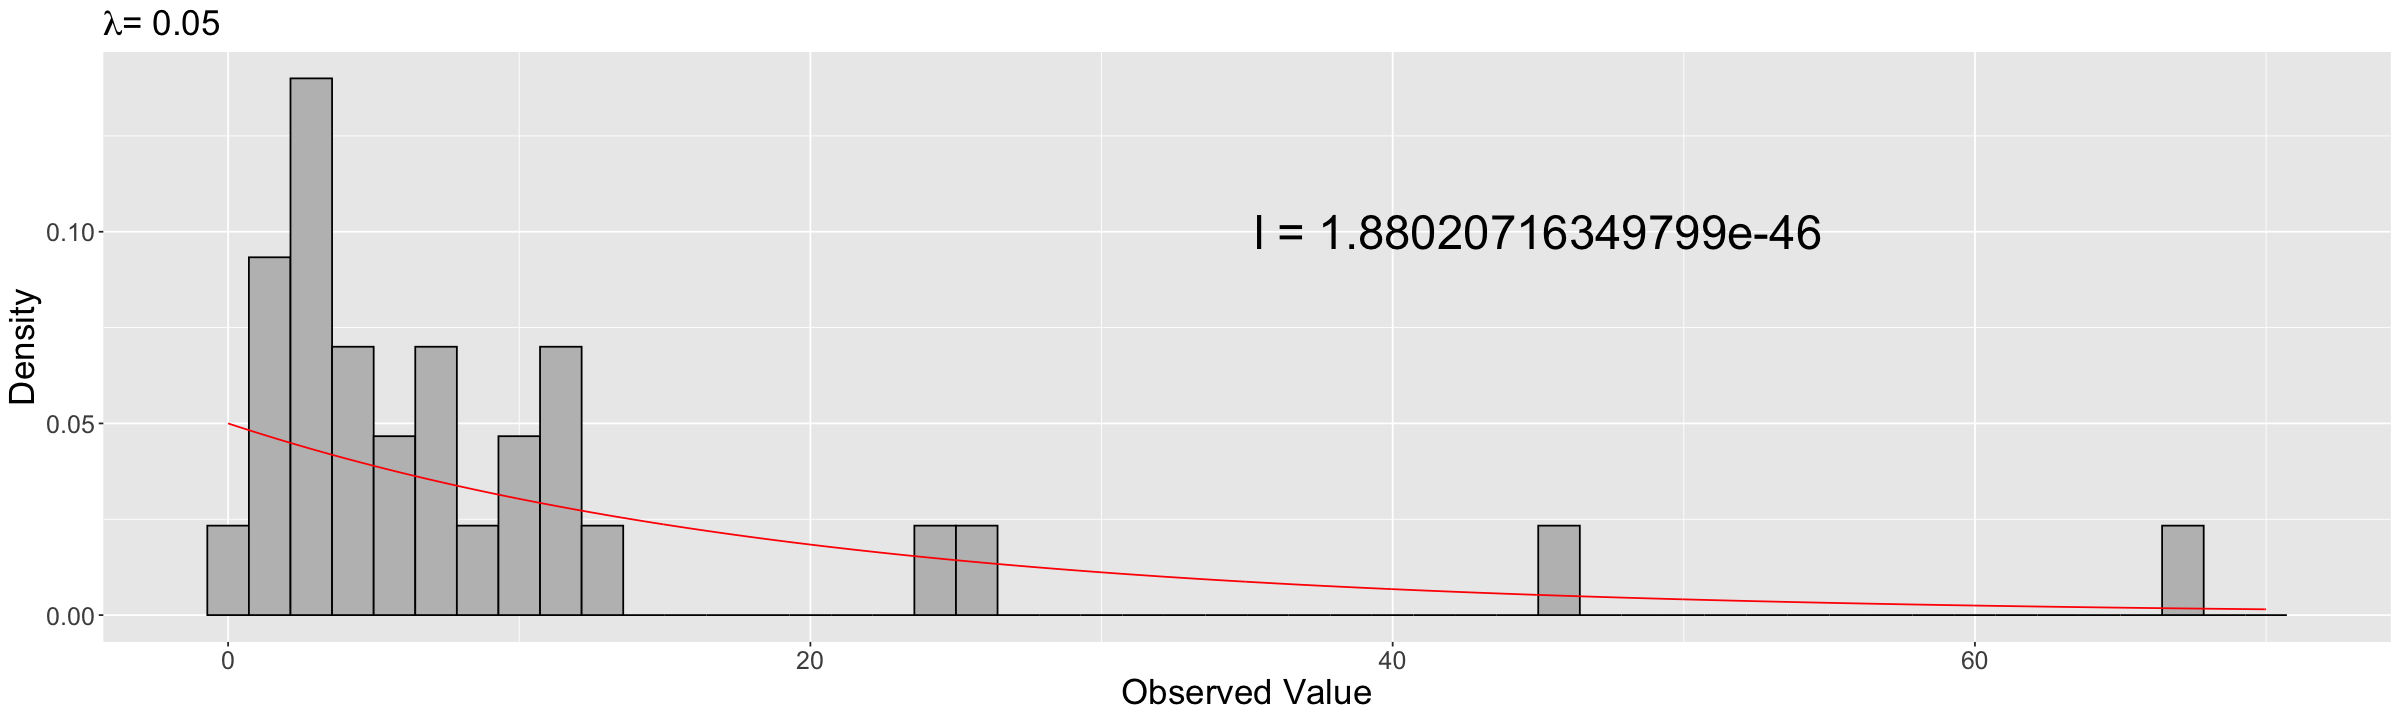

In [10]:
plot_lambda_0.05 <- hist_sample_n30 +
  geom_line(
    data = density_0.05,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.05), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.05")))

plot_lambda_0.05

Now for $\lambda$ values of $0.125$ and $0.5$:

In [11]:
likelihood_0.125 <- prod(dexp(sample_n30$values, 0.125))

density_0.125 <- tibble(
  x = seq(0, 70, 0.125),
  density = dexp(x, 0.125)
)

likelihood_0.5 <- prod(dexp(sample_n30$values, 0.5))

density_0.5 <- tibble(
  x = seq(0, 70, 0.5),
  density = dexp(x, 0.5)
)

In [12]:
plot_lambda_0.125 <- hist_sample_n30 +
  geom_line(
    data = density_0.125,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.125), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.125")))

plot_lambda_0.5 <- hist_sample_n30 +
  geom_line(
    data = density_0.5,
    aes(x = x, y = density), colour = "red"
  ) +
  annotate("text", x = 45, y = 0.1, label = paste0("l = ", likelihood_0.5), size = 10) +
  ggtitle(expression(paste(lambda, "= 0.5")))

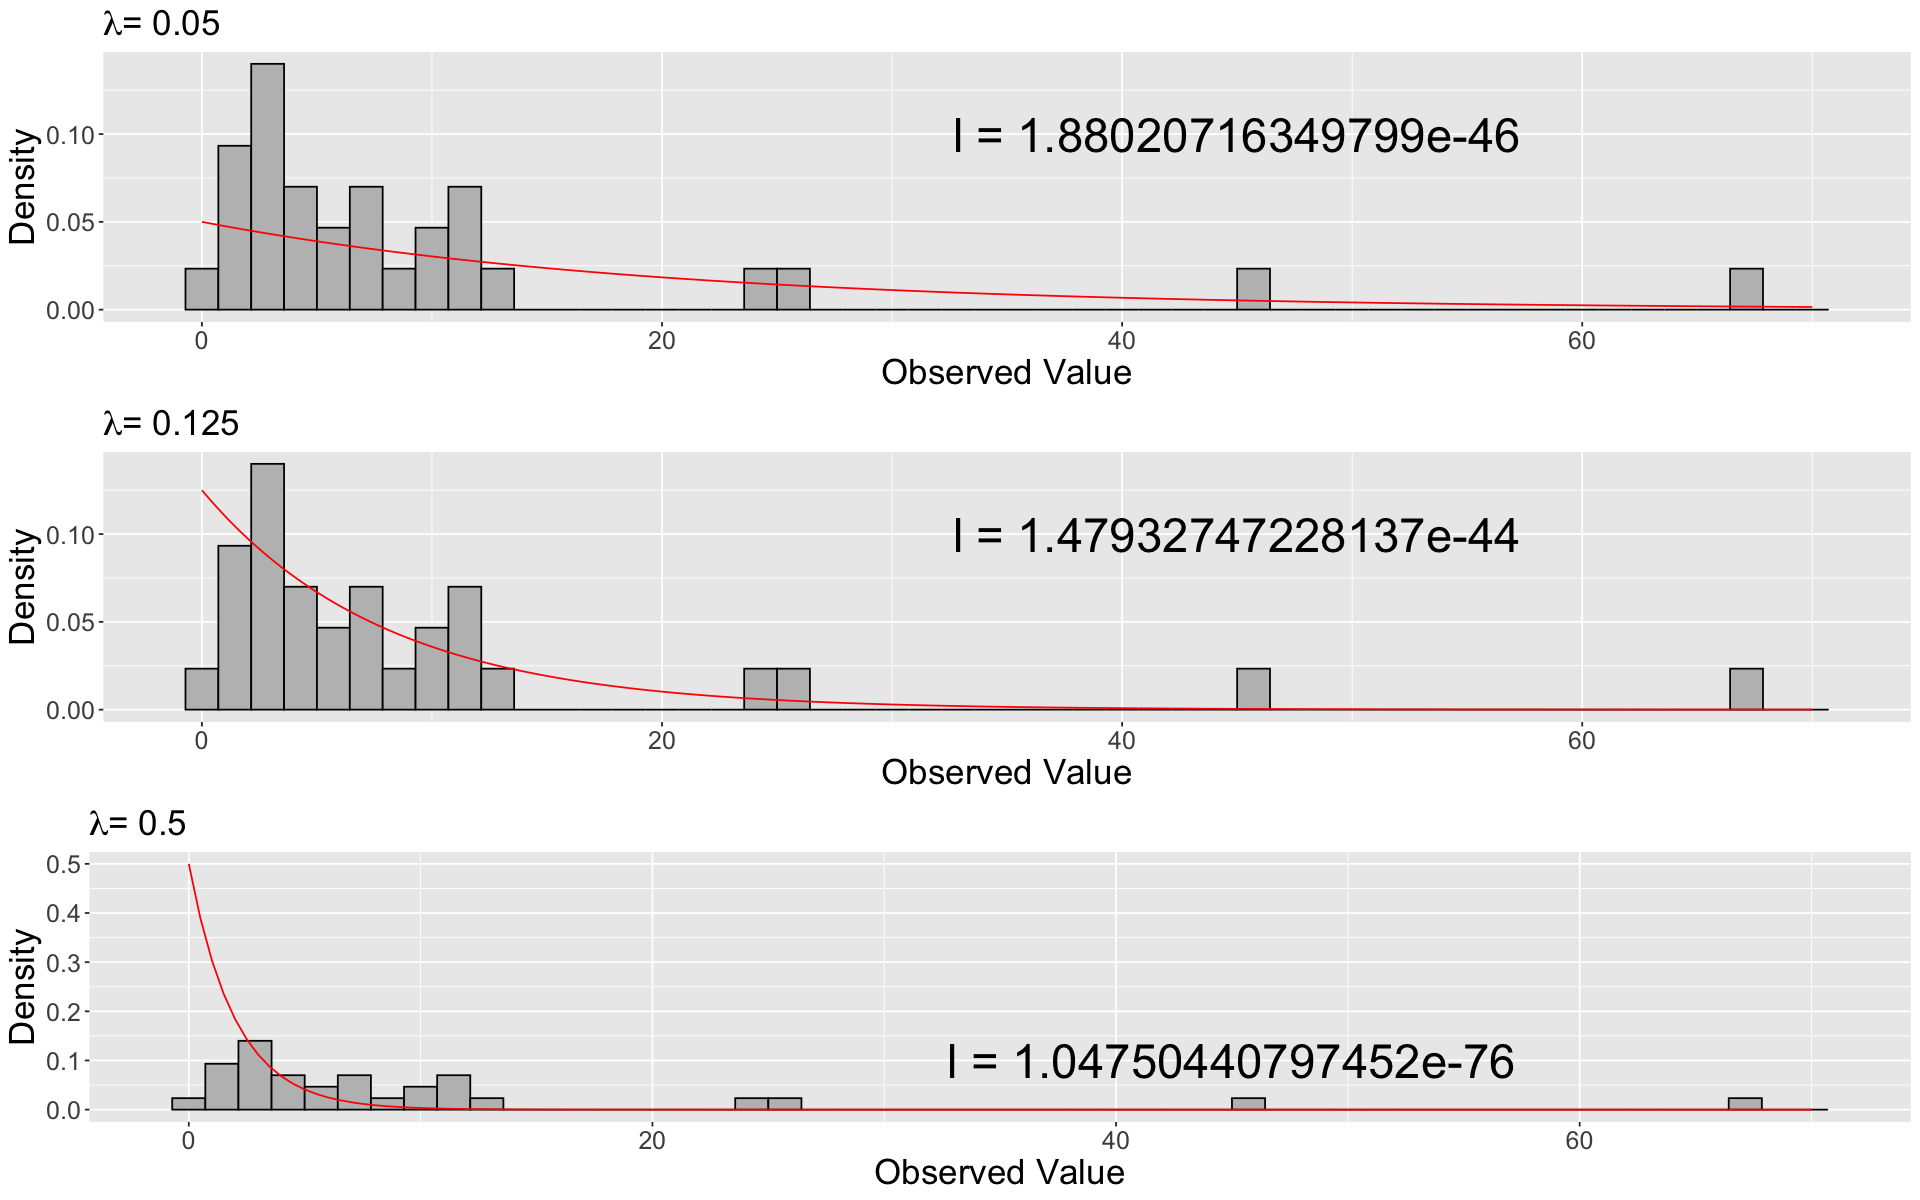

In [13]:
options(repr.plot.width = 16, repr.plot.height = 10)
grid.arrange(plot_lambda_0.05, plot_lambda_0.125, plot_lambda_0.5, nrow = 3)

We can see that the greatest likelihood value maps onto the exponential distribution that best fits the observed data! This is great. However, to find the maximum likelihood value (and hence best $\lambda$ to specify our specific exponential distribution) using this approach would take forever and/or be impossible.

Let us instead calculate and visualize the likelihoods for a wide range of $\lambda$'s and choose the specific distribution with the maximum likelihood.

> **Heads-up:** Even though we will automatically try a wide range of $\lambda$ values to obtain the one that yields the maximum likelihood, **this is not an analytical solution but empirical**.

## Interlude: the wonders of log-likelihood

Let us re-check the three previous likelihood values coming from `sample_n30`:

In [14]:
likelihood_0.05
likelihood_0.125
likelihood_0.5

[1] 1.880207e-46

[1] 1.479327e-44

[1] 1.047504e-76

Likelihood values are super small! Hence, we could make a logarithmic transformation on the base $e$ (i.e., a monotonic transformation) on the likelihood function: **the log-likelihood function**.

In [15]:
round(log(as.numeric(likelihood_0.05)), 4)
round(log(as.numeric(likelihood_0.125)), 4)
round(log(as.numeric(likelihood_0.5)), 4)

[1] -105.2875

[1] -100.9222

[1] -174.9501

The use of the log-likelihood function is common in MLE.

As previously stated, we would not know the real value for $\lambda$. The empirical use above, to estimate the value for $\lambda$, shows us that $\lambda = 0.125$ provides the *maximum* value for the log-likelihood function **from these three possible options**. This $\lambda = 0.125$ is the value for which our random sample is more likely (under the assumption of an exponential distribution).

## Finding the maximum likelihood and log-likelihood using a range of $\lambda$ values

Let us calculate the likelihoods and log-likelihood for a range of $\lambda$ for our `hist_sample_n30` and then plot these. We will try $0.1$ to $0.2$.

In [16]:
exp_values <- tibble(
  possible_lambdas = seq(0.01, 0.2, 0.001),
  likelihood = map_dbl(possible_lambdas, ~ prod(dexp(sample_n30$values, .))),
  log_likelihood = map_dbl(possible_lambdas, ~ log(prod(dexp(sample_n30$values, .))))
)
exp_values

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.010,4.581642e-62,-141.2382
0.011,5.873592e-61,-138.6872
0.012,5.870333e-60,-136.3852
⋮,⋮,⋮
0.198,2.444408e-48,-109.6303
0.199,2.088875e-48,-109.7875
0.200,1.783701e-48,-109.9454


Plot the possible $\lambda$'s against the likelihood of observing them given our data:

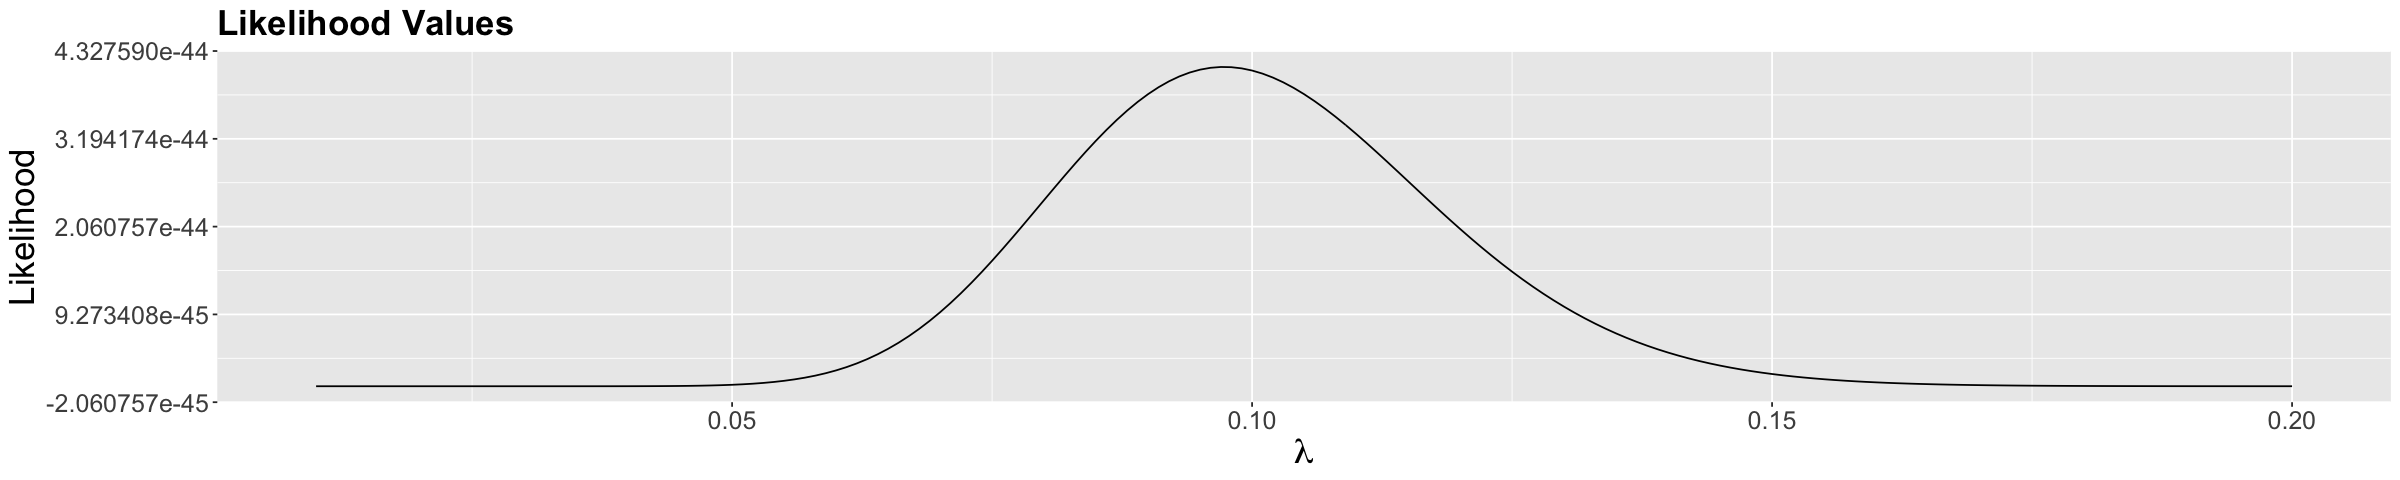

In [17]:
options(repr.plot.height = 4, repr.plot.width = 20)
(exp_like_plot <- ggplot(exp_values, aes(x = possible_lambdas, y = likelihood)) +
  geom_line() +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text = element_text(size = 15),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Likelihood Values") +
  labs(x = expression(lambda), y = "Likelihood"))

How about the log-likelihood values?

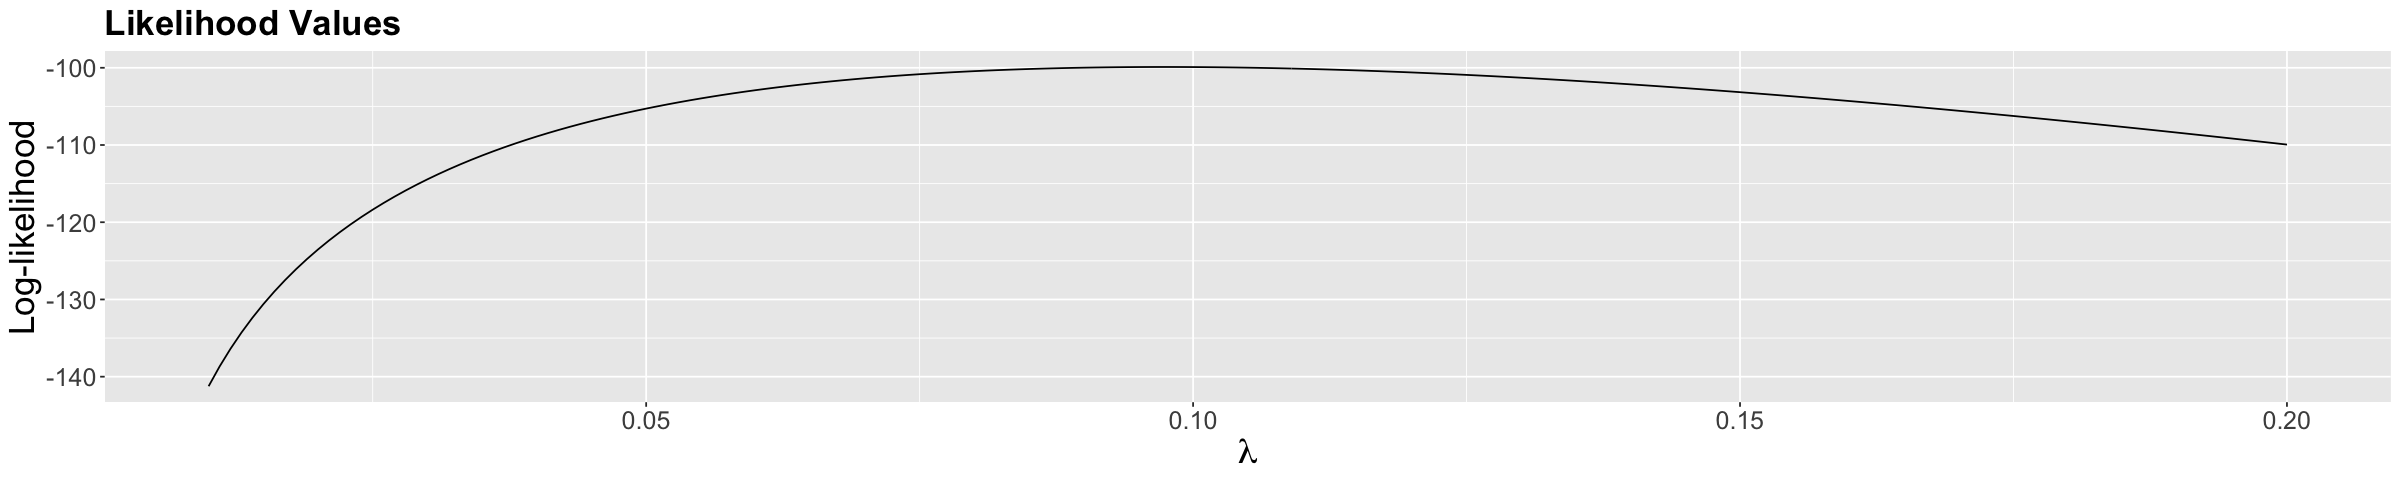

In [18]:
(exp_log_like_plot <- ggplot(exp_values, aes(x = possible_lambdas, y = log_likelihood)) +
  geom_line() +
  theme(
    plot.title = element_text(size = 21, face = "bold"),
    axis.text = element_text(size = 15),
    axis.title = element_text(size = 21)
  ) +
  ggtitle("Likelihood Values") +
  labs(x = expression(lambda), y = "Log-likelihood"))

What is the maximum? Reading off the graph is a bit difficult, so we will grab the maximum:

In [19]:
empirical_MLE <- exp_values %>%
  arrange(desc(likelihood)) %>%
  slice(1)
empirical_MLE

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.097,4.121515e-44,-99.89752


> **Note:** The precision of the maximum likelihood estimate we can come up with, **using this empirical method**, depends on the increments by which we vary $\lambda$.

# Can we apply MLE analytically?

### Yes, we can! 

And it will involve multivariate calculus since we have an optimization problem.

## Let us do it with $\lambda$ in the exponential distribution!

1. We will generalize our proof (yes, this is a proof!) by assuming a random sample of $n$ observations (they are independent and identically distributed). Recall that the $i$th observation ($i = 1, \dots, n$) has the following PDF:

$$
f_{Y_i}(y_i \mid \lambda) = \lambda \exp(-\lambda y_i).
$$

2. Since the $n$ observations are assumed independent, the joint PDF is as folllows:

$$
f_{Y_1, \dots, Y_n}(y_1, \dots, y_n \mid \lambda) = \prod_{i = 1}^n \lambda \exp(-\lambda y_i).
$$

3. The joint likelihood function is mathematically equivalent to the joint PDF. Thus, along with some algebraic rearrangements, we have:

$$
\mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = \prod_{i = 1}^{n} \lambda \exp(-\lambda y_i) = \lambda^n \exp \bigg( -\lambda \sum_{i = 1}^n y_i \bigg).
$$

4. Now, we apply some logarithmic properties to obtain the log-likelihood function:

$$
\log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = n \log \lambda - \lambda \sum_{i = 1}^n y_i.
$$

5. We take the first partial derivative, with respect to $\lambda$, of the the joint log-likelihood function:

$$
\frac{\partial}{\partial \lambda} \log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = \frac{n}{\lambda} - \sum_{i = 1}^n y_i.
$$

6. Then, we set this derivative equal to zero and solve for $\lambda$:

$$\frac{n}{\lambda} - \sum_{i = 1}^n y_i = 0$$
$$\hat{\lambda} = \frac{1}{\bar{Y}}.$$

> **Heads-up:** Since we are obtaining the maximum likelihood **estimator**, the notation in $\hat{\lambda}$ on the right-hand side changes to uppercases (random variables).

7. Is $\hat{\lambda}$ a maximum? We can use the second derivative criterion:

$$
\frac{\partial^2}{\partial \lambda} \log \mathscr{l}(\lambda \mid y_1, \dots , y_{n}) = -\frac{n}{\lambda^2} < 0.
$$

> **Note:** These seven steps also apply to other distributional parameters. For instance, $\mu$ and $\sigma^2$ in the normal distribution, or $\lambda$ in the Poisson distribution.

## Therefore...

Let us convince ourselves of this by overlaying $\hat{\lambda}$ using our observed `sample_n30` on our likelihood plot:

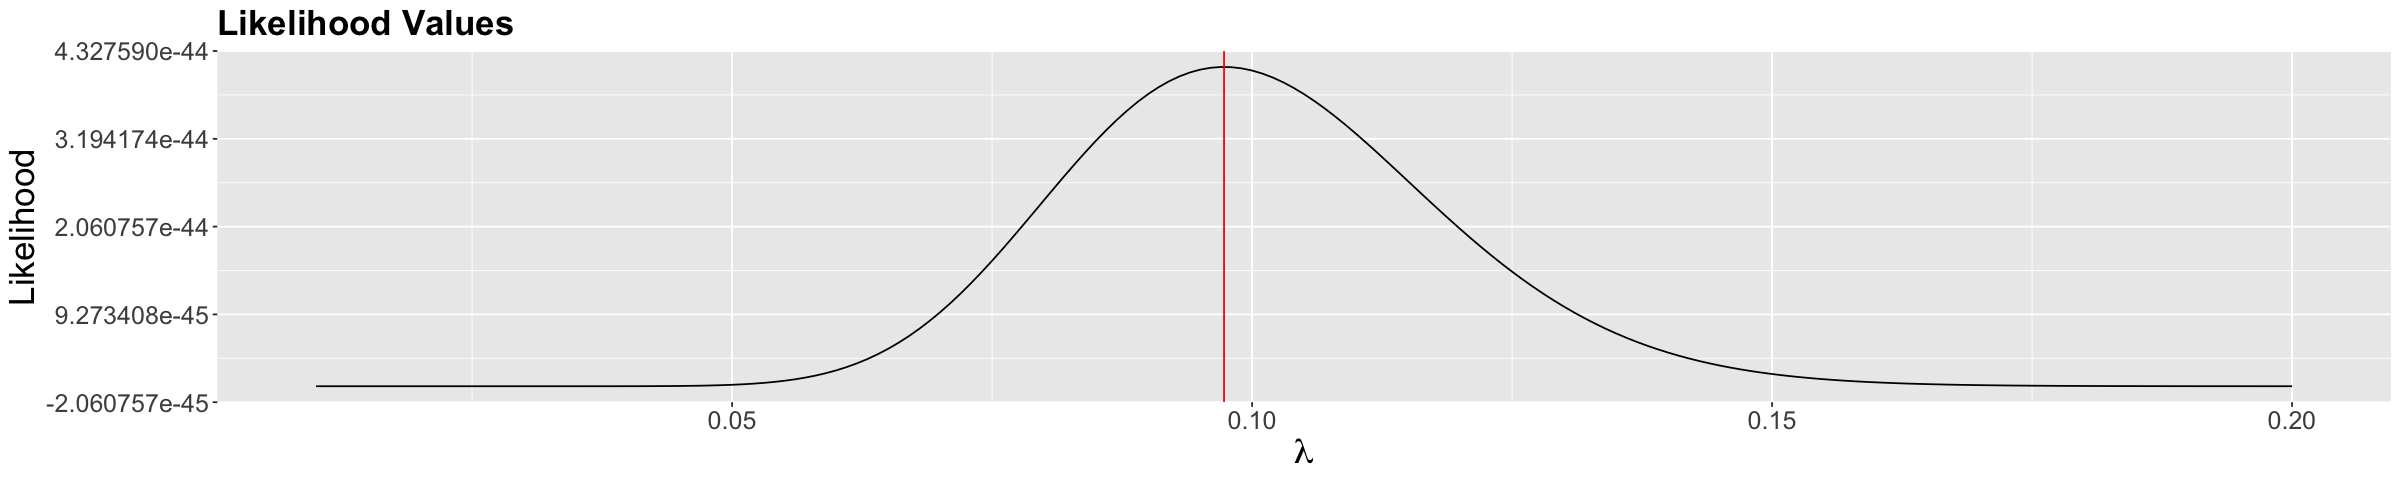

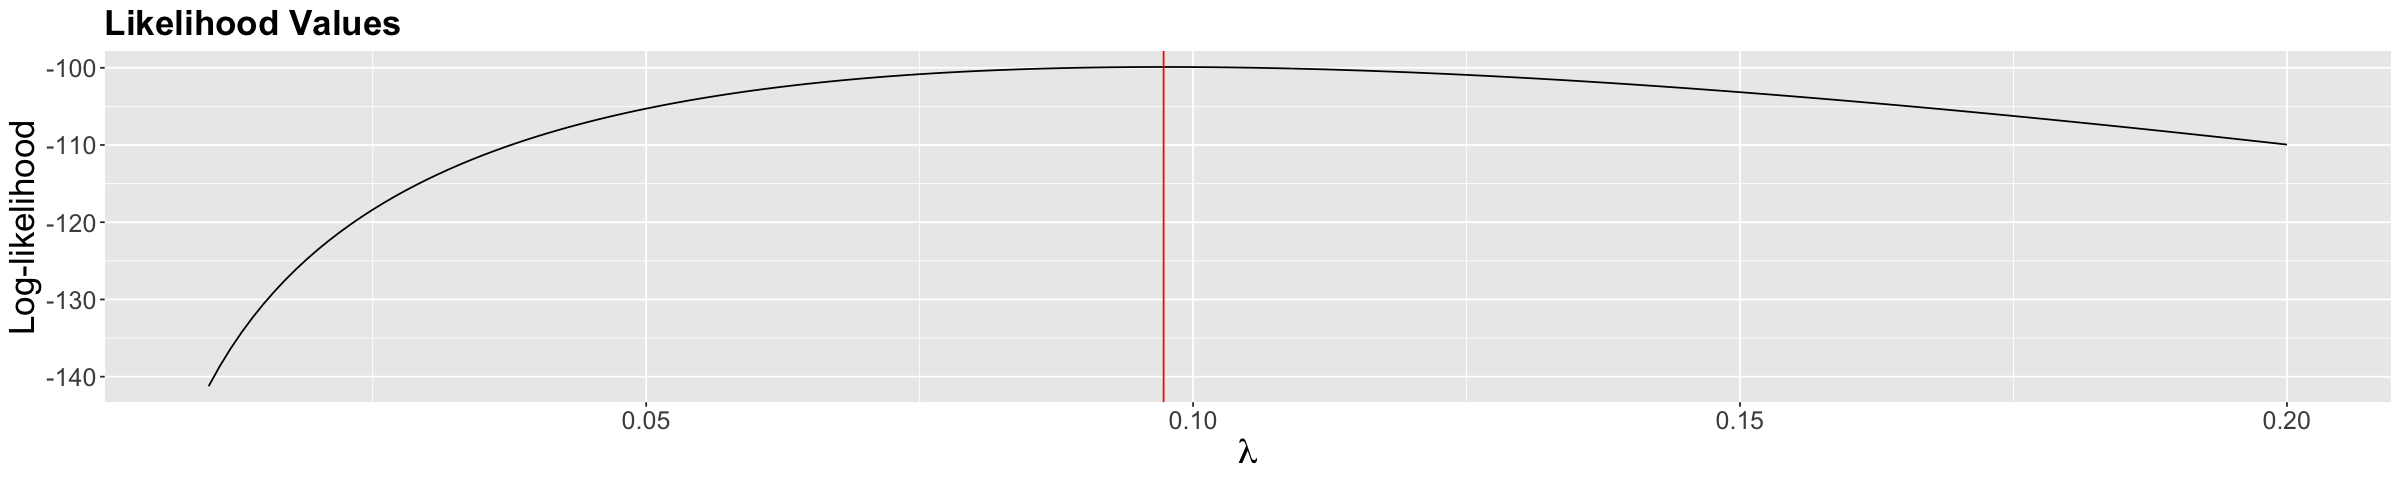

In [20]:
analytical_MLE <- 1 / sample_n30 %>%
  pull(values) %>%
  mean()

exp_like_plot +
  geom_vline(xintercept = analytical_MLE, colour = "red")

exp_log_like_plot +
  geom_vline(xintercept = analytical_MLE, colour = "red")

## What if we compare this analytical result versus the empirical one?

In [21]:
empirical_MLE
analytical_MLE

possible_lambdas,likelihood,log_likelihood
<dbl>,<dbl>,<dbl>
0.097,4.121515e-44,-99.89752


[1] 0.09730426

## Bam! It is the maximum!

## Probability versus Likelihood

Let us suppose we have a standard normal random variable $X$, i.e.,

$$
X \sim \mathcal{N}(\mu = 0, \sigma^2 = 1).
$$

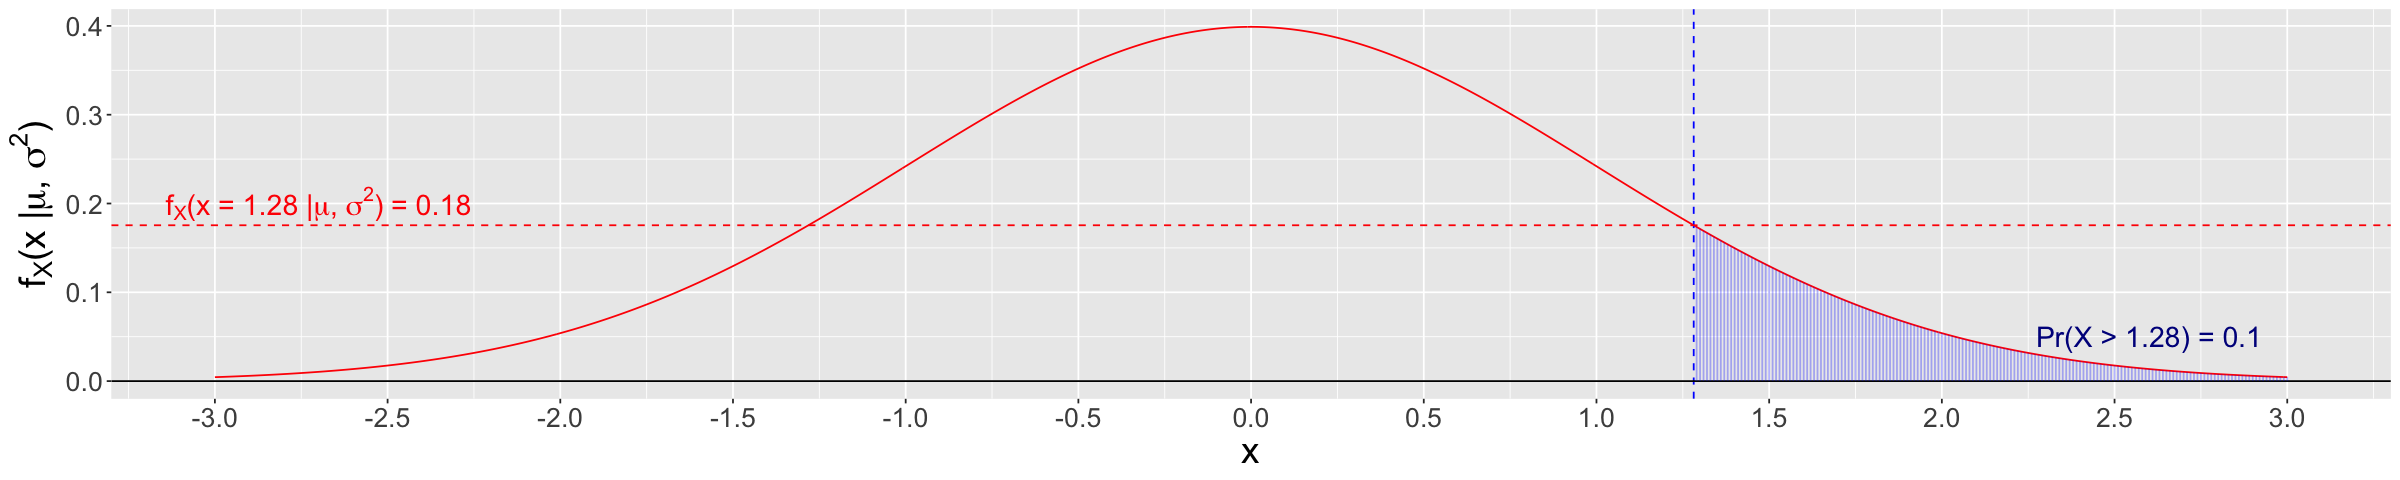

In [22]:
suppressWarnings(suppressMessages(print(prob_vs_likelihood())))

The plot shows $f_X(x \mid \mu, \sigma^2)$ on the vertical axis versus the corresponding quantiles
on the horizontal axis. We could establish the difference between **probability** and **likelihood**, in a continuous random variable, as follows:

- A **probability** is indicated as in the shaded blue area, e.g., $P(X > 1.28) = 0.1$. This is the area under the density curve.
- A **likelihood** is indicated in the horizontal dashed red line, e.g., $f_X(x = 1.28 \mid \mu, \sigma^2) = 0.18$. It is the PDF value on the $y$-axis for a given fixed observed $x$.

# Wrapping up! 

MLE allows us to make inference on population parameters via the observed values of a random sample. This is a classical theory-based method where one needs to make strong distributional assumptions on the data. Moreover, the respective estimators are usually well-behaved (asymptotically speaking). We can even obtain confidence intervals for them.

It is essential to explore the foundations of this estimation approach since we use it in fields like regression or survival analysis. For instance, generalized linear models (GLMs) or parametric survival regression.

If we want to estimate assuming a distribution that has more than one parameter (e.g., $F$-distribution), things get a bit more complicated:

- Mathematically, solving this matter involves complex partial derivatives **without closed solution**.
- Numerical optimization in `R` is possible using the `optim()` function.

Finally, we need to stress that we saw two MLE paths: the **empirical** and **mathematical**.

## Steps for empirical MLE

### Step 1: Choose the right distribution for the $i$th ($i = 1 , \dots, n$) PDF or PMF

- Using information you know about your sample of size $n$, choose a family of distributions.
- Identify the corresponding PDF (for continuous data) or PMF (for discrete data).

### Step 2: Obtain the joint or PDF or PMF

Once we have the $i$th PDF or PMF, build the joint function.

### Step 3: Obtain the joint likelihood function

Recall this function is mathematically equivalent to the joint PDF or PMF.

### Step 4:  Obtain the joint log-likelihood function

Use the rules of logarithms on the joint likelihood function.

### Step 5: Vary the parameters for that family of distribution and calculate the likelihood or log-likelihood

- Use information about the data to help choose the range of values to vary the parameter over.
- Given your observed sample and the likelihood or log-likelihood functions, vary the parameter's value all over that range and compute their corresponding values.

### Step 6: Choose the parameter value that gives you the maximum likelihood or log-likelihood

This value will be the maximum likelihood estimate under which your observed data is most likely.

## Steps for analytical MLE

### Steps 1, 2, 3, and 4 are the same

### Step 5: Obtain the partial derivative with respect to the parameter of interest

You have to use the log-likelihood function since its form makes derivation easier.

### Step 6: Set the partial derivative equal to zero and solve for the parameter of interest

We are doing this because it is an optimization problem.

> **Heads-up:** In cases of no analytical solution in this step, we need a numerical optimization method. Hence, we cannot proceed with this step and the following one.

### Step 7: Check you have a maximum estimator

You can do it using the second partial derivative criterion with respect to the same parameter of interest.

# Supplementary Material (OPTIONAL)

## The use of the `optim()` function

Let us use `R`'s `optimize()`, to obtain $\hat{\lambda}$ with `sample_n30`. This function uses numerical optimization and finds the point where the slope is `0` (maximum). 

`optimize()` needs at least these 3 things:
- The log-likelihood function (that references your data)
- A range of values to vary the parameter over (here `0.01` to `0.2`).
- Whether to return the minimum or the maximum of the function.

In [24]:
LL <- function(l) log(prod(dexp(sample_n30$values, l)))
optimize(LL, c(0.01, 0.2), maximum = TRUE)

$maximum
[1] 0.09728478

$objective
[1] -99.89738

## MLE for more than one parameter!

The exponential case possibly seems trivial. However, let us suppose we are dealing with the estimation of the *coefficients* (also called *weights*) of a **binary logistic regression model**.

## What are the MLE steps in binary logistic regression?

### Step 1: Choose the right response distribution for the $i$th probability mass function (PMF)

We have the $i$th binary *response variable* (also known as an *output*) $Y_i$:

$$
Y_i =
\begin{cases}
1 \; \; \; \; \text{if there is a success},\\
0 \; \; \; \; \mbox{otherwise}.
\end{cases}
$$

> **Heads-up:** Note we are italicizing some terms in these steps. We are doing it to illustrate the equivalences between several concepts in Statistics and Machine Learning. This [dictionary](https://ubc-mds.github.io/resources_pages/terminology/) will be helpful throughout MDS to set a bridge between both fields.

Our distributional assumptions start with a random sample of size $n$ whose elements are **independent only** (not identically distributed, since each one has a different $\pi_i$). Given that we have binary responses ($i = 1, \dots, n$), then:

$$Y_i \sim \text{Bernoulli}(\pi_i).$$

> **Heads-up:** The parameter to estimate here, via MLE, will be the probability of success $\pi_i \in [0, 1]$. Note that we will have a different $\pi_i$ for each $Y_i$.

Therefore, the probability mass function (PMF) of the $i$th Bernoulli response is:

$$P_{Y_i}(Y_i = y_i \mid \pi_i) = \pi_i^{y_i} (1 - \pi_i)^{1 - y_i}.$$

### Step 2: Obtain the joint PMF

We can obtain the joint PMF of our random sample as follows:

$$P_{Y_1, \dots, Y_n} \big(Y_1 = y_1, \dots, Y_n = y_n \mid \pi_1, \dots, \pi_n \big) = \prod_{i = 1}^n \pi_i^{y_i} (1 - \pi_i)^{1 - y_i}.$$

### Step 3: Obtain the joint likelihood function

Recall that the joint likelihood function is mathematically equivalent to the joint PMF (we also make some algebraic rearrangements):

$$
\mathscr{l}(\pi_1, \dots, \pi_n \mid y_1, \dots , y_{n}) = \prod_{i = 1}^n \pi_i^{y_i} (1 - \pi_i)^{1 - y_i} = \prod_{i = 1}^n \bigg( \frac{\pi_i}{1 - \pi_i} \bigg)^{y_i} (1 - \pi_i).
$$

Moreover, since we are talking about a regression model, the $i$th binary response $Y_i$ is subject to $p$ *regressors* $X_{i, 1}, \dots, X_{i, p}$. 

How can we link these *regressors* (also known as *features*) with $\pi_i$? We can do it via the natural logarithm (i.e., on the base $e$) of the odds $\frac{\pi_i}{1 - \pi_i}$:

$$\log \bigg( \frac{\pi_i}{1 - \pi_i}\bigg) = \beta_0 + \sum_{j = 1}^p \beta_j X_{i, j};$$

where the $p$ *regression coefficients* (also known as *weights*) $\beta_1, \dots, \beta_p$ (along with the intercept $\beta_0$) will be estimated via maximum likelihood.

After some algebraic rearrangements, the natural logarithm of the odds can be put in terms of $\pi_i$ as follows:

$$\pi_i = \frac{\exp \big( \beta_0 + \sum_{j = 1}^p \beta_j X_{i, j} \big)}{1 + \exp \big( \beta_0 + \sum_{j = 1}^p \beta_j X_{i, j} \big)} = \frac{1}{1 + \exp \big( -\beta_0 - \sum_{j = 1}^p \beta_j X_{i, j} \big)}.$$

> **Heads-up:** This equation for $\pi_i$ is called the **sigmoid function**. It restricts $\pi_i$ on the range $[0, 1]$, since $\pi_i$ is a probability!

Given this sigmoid function and the equation for $\frac{\pi_i}{1 - \pi_i}$, note the following:

$$
\frac{\pi_i}{1 - \pi_i} = \exp{\bigg(\beta_0 + \sum_{j = 1}^p \beta_j X_{i, j}\bigg)} \\
\text{and}\\
1 - \pi_i = \frac{1}{1 + \exp \big( \beta_0 + \sum_{j = 1}^p \beta_j X_{i, j} \big)}.
$$


Therefore, the joint likelihood function becomes:

$$\mathscr{l}(\beta_0, \dots, \beta_p \mid y_1, \dots , y_{n}, x_{1,1}, \dots, x_{1,p}, \dots, x_{n,1}, \dots, x_{n,p}) = \prod_{i = 1}^n \bigg[ \exp{\bigg(\beta_0 + \sum_{j = 1}^p \beta_j x_{i, j}\bigg)} \bigg]^{y_i} \bigg[ \frac{1}{1 + \exp \big( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \big)} \bigg]$$

> **Heads-up:** Note that both response and regressors' notations are in lowercases because the joint likelihood incorporates the **observed** values.

### Step 4: Obtain the joint log-likelihood function

By applying the rules of logarithms, we have:

$$
\log \mathscr{l}(\beta_0, \dots, \beta_p \mid y_1, \dots , y_{n}, x_{1,1}, \dots, x_{1,p}, \dots, x_{n,1}, \dots, x_{n,p}) = \sum_{i = 1}^n y_i \bigg( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \bigg) - \sum_{i = 1}^n \log \bigg[ 1 +  \exp \bigg( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \bigg) \bigg].
$$

### Step 5: Take the first partial derivatives with respect to $\beta_0, \beta_1, \dots, \beta_p$

For $\beta_0$, we have:

$$
\frac{\partial}{\partial \beta_0} \log \mathscr{l}(\beta_0, \dots, \beta_p \mid y_1, \dots , y_{n}, x_{1,1}, \dots, x_{1,p}, \dots, x_{n,1}, \dots, x_{n,p}) = \sum_{i = 1}^n \Bigg[ y_i - \frac{\exp \big( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \big)}{1 + \exp \big( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \big)} \Bigg].
$$

For $j = 1, \dots, p$; we have:

$$
\frac{\partial}{\partial \beta_j} \log \mathscr{l}(\beta_0, \dots, \beta_p \mid y_1, \dots , y_{n}, x_{1,1}, \dots, x_{1,p}, \dots, x_{n,1}, \dots, x_{n,p}) = \sum_{i = 1}^n \Bigg[ y_i x_{i, j} - x_{i, j} \frac{\exp \big( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \big)}{1 + \exp \big( \beta_0 + \sum_{j = 1}^p \beta_j x_{i, j} \big)} \Bigg].
$$

### Nonetheless, there is a problem here...

We cannot continue with **Step 6**, i.e., solving the system of $p + 1$ equations if we set them equal to zero. Mathematically, there is no closed-form solution for this system. 

Nonetheless, we can solve it through numerical optimization (e.g., the function `optim()`). Note that regression models, such as binary logistic regression, have their own fitting function. In this case, the function to use is `glm()`. In terms of `R`, we will explore this in further detail in **DSCI 562 - Regression II**.